In [1]:
import os
import numpy as np
import qiskit
import qiskit_superstaq as qss
from qiskit.quantum_info import Operator
from qiskit import *
from qiskit.tools.visualization import plot_histogram

np.set_printoptions(linewidth=np.inf)
provider = qss.SuperstaqProvider(api_key="bccc3907f5bbfa1658a94ab3fd2d8b5d316e744ce9402585d7e20961078e4570")

In [2]:
# getting QMARINA circuit list

# Number of emitters
N = 3

# Cavity linewidth and time
kappa = 5      # cavity linewidth
g = 2         # in 2pi*GHz
tlist = np.linspace(0,3,51)  #in ns

# Initial emitter excitation
c0 = [1]
for i in range(N-1):
    c0.append(0)

shots = 10000
population1 = []
population2 = []
all_qc = []

for t in tlist:

    # Quantum register
    qr = QuantumRegister(N+1, name='q')
    cr = ClassicalRegister(N+1, name='c')

    # Quantum circuit
    qc = QuantumCircuit(qr,cr)

    environment = N # index of the last qubit
    
    # Laplace transform terms
    c = []
    P = kappa*kappa-16*g*g*N
    if P>0:
        D = np.sqrt(P)
        
    else:
        D = np.sqrt(-P)
        
    sum_c = 0
    for i in range(N):
        sum_c = sum_c + c0[i]
        
    c = []
    for i in range(N):
        c.append((N*c0[i] - sum_c)/N + sum_c*np.exp(-kappa*t/4)*(kappa/D *np.sin(D*t/4)+ np.cos(D*t/4))/N)
            
    # Quantum circuit coefficients
    theta = []
    coef = 1
    for i in range(N):
        if i == 0:
            theta.append(np.arccos(c[0]))
            coef = np.sin(theta[0])
        else:
            if c[i] == 0:
                theta.append(0)
            else:
                theta.append(np.arcsin(c[i]/coef))
            coef = coef * np.cos(theta[i])
    
    # Construct quantum circuit
    qc.x(0)
    qc.cu(2 * theta[0], 0, 0, 0, 0, environment)
    qc.cx(environment, 0)
    
    for i in range(N-1):
        qc.cu(2 * theta[i+1], 0, 0, 0, environment, i+1)
        qc.cx(i+1, environment)
    
    #qc.barrier()
  
    for i in range(N+1):
        qc.measure(i,i)

    all_qc.append(qc)

In [5]:
# compiler_output = provider.qscout_compile(qc)

compiled_circuits_zz = provider.qscout_compile(all_qc[-1], base_entangling_gate='xx', mirror_swaps=False)

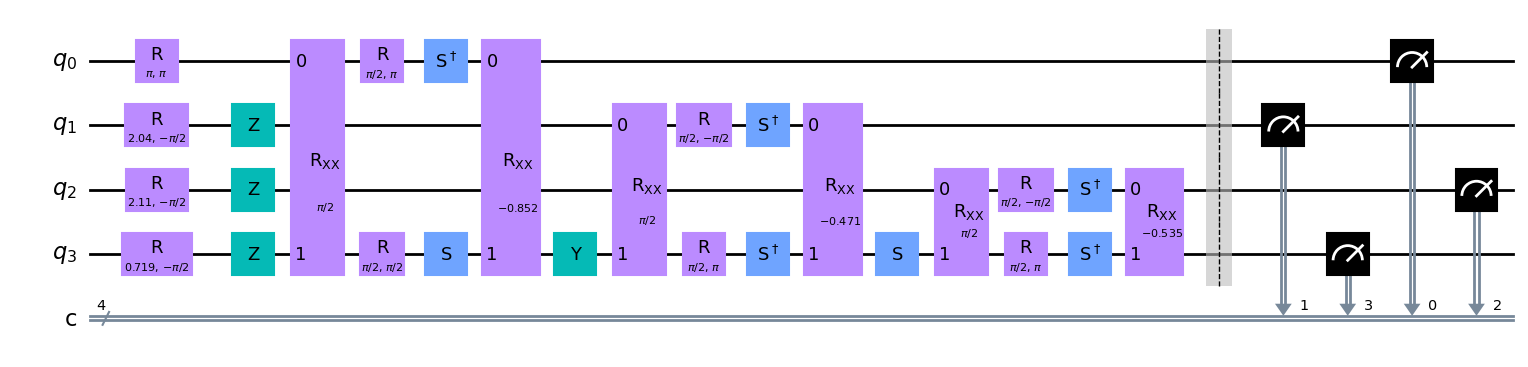

In [6]:
compiled_circuits_zz.circuit.draw('mpl')

/Users/alexrubin/code/Tavis-Cummings-simulations/.venv/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  def draw(self, filename=None, verbose=False):


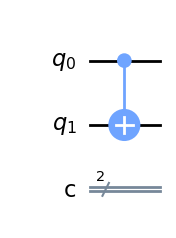

In [6]:
qc = QuantumCircuit(2,2)
qc.cx(0, 1)
qc.draw('mpl')

In [7]:
compiled_circuits_zz = provider.qscout_compile(qc, base_entangling_gate='zz', mirror_swaps=False)

SuperstaqServerException: Internal Server Error (Status code: 500)

If you would like to contact a member of our team, email us at superstaq@infleqtion.com or join our Slack workspace: https://join.slack.com/t/superstaq/shared_invite/zt-1wr6eok5j-fMwB7dPEWGG~5S474xGhxw.

In [ ]:
compiled_circuits_zz.circuit.draw('mpl')

In [ ]:
simulator = Aer.get_backend('unitary_simulator')
result = qiskit.execute(compiled_circuits_zz.circuit, backend=simulator, shots=10000).result()
np.real(result.get_unitary(compiled_circuits_zz.circuit)).astype(int)

In [ ]:
qc = QuantumCircuit(2)
# qc.r(np.pi/2, np.pi/2, 1)
# qc.rzz(np.pi/2, 0, 1)
# qc.s(0)
qc.sx(1)
qc.sdg(1)
qc.draw('mpl')

In [ ]:
simulator = Aer.get_backend('unitary_simulator')
result = qiskit.execute(qc, backend=simulator, shots=10000).result()
result.get_unitary(qc, decimals=2)

In [ ]:
qc = QuantumCircuit(2)
qc.x(0)
qc.cx(0, 1)
qc.measure_all()
qc.draw('mpl')

In [ ]:
simulator = Aer.get_backend('statevector_simulator')
result = qiskit.execute(qc, backend=simulator, shots=10000).result()
plot_histogram(result.get_counts())

In [ ]:
qc = QuantumCircuit(2)
qc.cu(1, 0, 0, 0, 0, 1)
qc.draw('mpl')

In [ ]:
simulator = Aer.get_backend('unitary_simulator')
result = qiskit.execute(qc, backend=simulator, shots=10000).result()
result.get_unitary(qc, decimals=3)

In [ ]:
compiled_circuits_zz = provider.qscout_compile(qc, base_entangling_gate='zz', mirror_swaps=False)
compiled_circuits_zz.circuit.draw('mpl')

In [ ]:
simulator = Aer.get_backend('unitary_simulator')
result = qiskit.execute(compiled_circuits_zz.circuit, backend=simulator, shots=10000).result()
result.get_unitary(compiled_circuits_zz.circuit, decimals=3)

In [ ]:
qc = QuantumCircuit(2)
qc.cu(1, 0, 0, 0, 0, 1)
qc.cx(1,0)
qc.draw('mpl')

In [ ]:
compiled_circuits_zz = provider.qscout_compile(qc, base_entangling_gate='zz', mirror_swaps=False)
compiled_circuits_zz.circuit.draw('mpl')

In [ ]:
frfrom qiskit import execute
from qiskit_aer import Aer
from qiskit_aer.noise import NoiseModel
from qiskit.providers.fake_provider import FakeLima

def run_circuit(ckt, shots, use_noise_model: bool = False):
    """
    Execute `ckt` on a simulator.
    If `use_noise_model` is True, we use the `FakeLima` noise model.
    """
    simulator = Aer.get_backend("qasm_simulator")
    if use_noise_model:
        device_backend = FakeLima()
        noise_model = NoiseModel.from_backend(device_backend)
        result = execute(
            ckt, backend=simulator, shots=shots, noise_model=noise_model
        ).result()

    else:
        result = execute(ckt, backend=simulator, shots=shots).result()

    return result.get_counts()